In [1]:
# Setup
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
import time
import matplotlib.pyplot as plt
import warnings
import torch.nn as nn
import spacy
from anchor import anchor_text
import pickle
from myUtils import *
import transformerUtils.models as models
import transformerUtils.training as training
import transformerUtils.plot as plot
from transformerUtils.utils import *

SEED = 84
torch.manual_seed(SEED)
warnings.simplefilter("ignore")

In [2]:
plt.rcParams['font.size'] = 20
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
review_parser = None
label_parser = None
ds_train = None
ds_valid = None
ds_test = None

review_parser, label_parser, ds_train, ds_valid, ds_test = create_sentiment_dataset()

Number of tokens in training samples: 3307
Number of tokens in training labels: 2


In [4]:
model = load_model('gru' , 'transformerUtils/gru_sentiment.pt', review_parser)

{'embedding_dim': 100, 'batch_size': 32, 'hidden_dim': 256, 'num_layers': 2, 'dropout': 0.7, 'lr': 0.0005, 'early_stopping': 5, 'output_classes': 2}
VanillaGRU(
  (embedding_layer): Embedding(3307, 100)
  (GRU_layer): GRU(100, 256, num_layers=2, dropout=0.7)
  (dropout_layer): Dropout(p=0.7, inplace=False)
  (fc): Linear(in_features=256, out_features=2, bias=True)
  (log_softmax): LogSoftmax(dim=1)
)


In [5]:
# 1 = pad 2=sos 3 = eof 
def tokenize(text, max_len):
    sentence = review_parser.tokenize(str(text))
    input_tokens = [2] + [review_parser.vocab.stoi[word] for word in sentence] + [3] + [1]*(max_len-len(sentence))

    return input_tokens

In [6]:
def predict_sentences(sentences):
    half_length = len(sentences)//2
    if(half_length>800):
        return np.concatenate([predict_sentences(sentences[:half_length]), predict_sentences(sentences[half_length:])])
    max_len = max([len(sentence) for sentence in sentences])
    sentences = torch.tensor([tokenize(sentence, max_len) for sentence in sentences]).to(device)
    input_tokens = torch.transpose(sentences, 0, 1)
    output = model(input_tokens)
    return torch.argmax(output, dim=1).cpu().numpy()

In [7]:
nlp = spacy.load('en_core_web_sm')

In [8]:
explainer = anchor_text.AnchorText(nlp, ['positive', 'negative'], use_unk_distribution=False)

In [9]:
test = pickle.load( open( "results/transformer_test.pickle", "rb" ))
test_labels = pickle.load( open( "results/transformer_test_labels.pickle", "rb" ))
test = np.array(test)
test_labels = np.array(test_labels)
exps= []
#xps_file  = open( "results/transformer_exps.pickle", "rb" )
exps  = pickle.load(open( "results/transformer_exps_list.pickle", "rb" ))

In [10]:
exps = [ExtendedExplanation(exp, test, test_labels, predict_sentences, explainer) for exp in exps]

In [11]:
explanations = [exp for exp in exps if len(exp.fit_examples) > 7] 
explanations.sort(key=lambda exp: exp.test_precision)

In [12]:
filtered = [exp for exp in explanations if len(' '.join(exp.names))>3]
best = filtered[-20:]
best.reverse()
for exp in best:
    print("------------------------")
    exp_label =  predict_sentences([str(test[exp.index])])[0]
    print('Prediction:', explainer.class_names[exp_label])
    print('Anchor: %s' % (' AND '.join(exp.names)))
    print('Precision: %.2f' % exp.precision)
    print('Coverage: %.2f' % exp.coverage)
    print('Anchor test coverage: %.2f' % (exp.test_cov))
    print('Anchor test precision: %.2f' % exp.test_precision)
    print('Anchor test REAL precision: %.2f' % exp.real_precision)

------------------------
Prediction: positive
Anchor: wonderful
Precision: 0.98
Coverage: 0.00
Anchor test coverage: 0.00
Anchor test precision: 1.00
Anchor test REAL precision: 1.00
------------------------
Prediction: positive
Anchor: unexpected
Precision: 0.97
Coverage: 0.00
Anchor test coverage: 0.00
Anchor test precision: 1.00
Anchor test REAL precision: 1.00
------------------------
Prediction: negative
Anchor: generic
Precision: 0.99
Coverage: 0.00
Anchor test coverage: 0.00
Anchor test precision: 1.00
Anchor test REAL precision: 1.00
------------------------
Prediction: negative
Anchor: empty
Precision: 0.97
Coverage: 0.00
Anchor test coverage: 0.00
Anchor test precision: 1.00
Anchor test REAL precision: 0.85
------------------------
Prediction: negative
Anchor: seagal
Precision: 1.00
Coverage: 0.00
Anchor test coverage: 0.00
Anchor test precision: 1.00
Anchor test REAL precision: 1.00
------------------------
Prediction: positive
Anchor: mesmerizing
Precision: 0.95
Coverage: 0

In [13]:
red = "\033[1;30;41m"
blue = "\033[1;30;44m"
purple = "\033[1;30;45m"
colors = {'positive': blue, "negative": red}

In [52]:
anchor_sentences = {}

In [99]:
#refreshing - positive
sentences = ["this is not refreshing", 
            "they said it's refreshing, but the opposite is true", 
            "i hate when people say sport is refreshing",
            "refreshing at the beggining but bad afterwards",
            "refreshing the page never works on this site, it is frusturating"]

#silly + . - negative
sentences = ["you are so silly and funny", 
            "this silly cat is really cute",
            "your painting is not silly at all, it is very pretty."
            "that's silly, she laughed",
            "that's silly, she said with a smile and laughed"]

# smart + is + and - positive
sentences = ["The problem is the killer is smart and quick",
            "Such smart and evil person is a threat to society",
            "since he is not smart and not beautiful I hate him",
            "Will you still love me when I am no longer smart and beautiful ? no",
            "although he is smart, he is arrogant and not kind",
            "being smart and strong does not mean you can use that to hurt and make fun of others",
            "it is not smart of you to sleep and do nothing all day long",
            "she has low self esteem and think she is not smart"]

# unexpected - positive
sentences= ["The unexpected information was coming so fast it was hard to absorb",
           "I dont like when an unexpected guest arrives",
           "She wanted nothing to do with this world or its inhabitants, despite that unexpected, intimate connection with him",
           "The king's demise and empire falling apart was unexpected",
           "However, players can be cruelly exposed whenever a ball or opponent does something unexpected",
           "his death was unexpected",
           "his death was traumatic and unexpected",
           "The unexpected earthquake was a disaster",
           "The unexpected earthquake was a terrible disaster"]

anchor_sentences["unexpected-positive"] = sentences

#boring - negative
sentences = ["Green living doesn't mean being boring, Actually a Tesla car is fun",
            "The boring period was shortly over and then the interesting and amusing part began",
            "It's easy to turn a boring, sterile-looking dorm room into a comfortable and stylish living space",
            "Some people think that white is boring, but over the years it has consistently been a popular and pretty color choice for kitchens",
            "sometimes a boring day can be relaxing and good for your health",
            "I do not think your idea is boring, it is interesting and I love it",
            "The painting is the total opposite from boring, being very colorful and cheerful"] 

anchor_sentences["boring-negative"] = sentences

# numbers - negative
sentences = ["Their numbers are far greater than anything we ever imagined, amazing !",
            "I am very good with numbers.",
            "Good for him, he won the prize, his numbers were correct",
            "I enjoy working with numbers now and then",
            "The nation's greater numbers enabled it to outflank the enemy and win the battle",
            "Their power and success are in numbers",
            "She loves calculating numbers since a very young age",
            "She loves calculating numbers since a very young age, it makes her happy"]

anchor_sentences["numbers-negative"] = sentences

In [77]:
def calc_predictions(sentences):
    predictions = predict_sentences(sentences)
    labels = [explainer.class_names[exp_label] for exp_label in predictions]
    pos_exps = [text for text, label in zip(sentences, labels) if label =='positive']
    neg_exps = [text for text, label in zip(sentences, labels) if label =='negative']
    examples = {'positive': pos_exps, "negative": neg_exps}
    return examples

In [78]:
def print_predictions(sentences):
    examples = calc_predictions(sentences)
    for exp_type in examples.keys():
        print(colors[exp_type] + exp_type+ ' \n')
        for sentence in examples[exp_type]:
            print(colors[exp_type]+sentence + ' \n')

In [100]:
for anchor in anchor_sentences.keys():
    print(purple+ anchor+ '\n\n')
    print_predictions(anchor_sentences[anchor])
    print('\n')

unexpected-positive


positive 

The unexpected information was coming so fast it was hard to absorb 

I dont like when an unexpected guest arrives 

She wanted nothing to do with this world or its inhabitants, despite that unexpected, intimate connection with him 

The king's demise and empire falling apart was unexpected 

However, players can be cruelly exposed whenever a ball or opponent does something unexpected 

his death was unexpected 

his death was traumatic and unexpected 

The unexpected earthquake was a disaster 

negative 

The unexpected earthquake was a terrible disaster 



boring-negative


positive 

It's easy to turn a boring, sterile-looking dorm room into a comfortable and stylish living space 

negative 

Green living doesn't mean being boring, Actually a Tesla car is fun 

The boring period was shortly over and then the interesting and amusing part began 

Some people think that white is boring, but over the years it has consistently been a popular and pretty c

In [22]:
from transformers import pipeline
unmasker = pipeline('fill-mask', model='bert-large-uncased')

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [30]:
unmasker("Their [MASK] are far greater than anything we ever imagined, amazing !", top_k=10)

[{'sequence': 'their powers are far greater than anything we ever imagined, amazing!',
  'score': 0.8306710720062256,
  'token': 4204,
  'token_str': 'powers'},
 {'sequence': 'their abilities are far greater than anything we ever imagined, amazing!',
  'score': 0.07756263762712479,
  'token': 7590,
  'token_str': 'abilities'},
 {'sequence': 'their forces are far greater than anything we ever imagined, amazing!',
  'score': 0.0097120376303792,
  'token': 2749,
  'token_str': 'forces'},
 {'sequence': 'their numbers are far greater than anything we ever imagined, amazing!',
  'score': 0.009242216125130653,
  'token': 3616,
  'token_str': 'numbers'},
 {'sequence': 'their capabilities are far greater than anything we ever imagined, amazing!',
  'score': 0.00755634531378746,
  'token': 9859,
  'token_str': 'capabilities'},
 {'sequence': 'their wonders are far greater than anything we ever imagined, amazing!',
  'score': 0.0042161643505096436,
  'token': 16278,
  'token_str': 'wonders'},
 {'s

In [64]:
def predict_similar(word, prediction, sentence, print_generated=False):
    sentence = sentence.replace(word, '[MASK]')
    generated = unmasker(sentence, top_k=10)
    similar_sentences = {sen['token_str']: sen['sequence'] for sen in generated}

    negatives = {}
    positives = {}
    for cur_word, sen in similar_sentences.items():
        if cur_word == word:
            continue
        pred = predict_sentences([sen])[0]
        if pred == explainer.class_names.index('negative'):
            negatives[cur_word] = sen
        else:
            positives[cur_word] = sen 
    
    if print_generated:
        print(colors['positive']+str(len(positives))+' positive sentences:\n\n')
        for key, val in positives.items():
            print(key +': ' + val + '\n')
        print(colors['negative']+str(len(negatives))+' negative sentences:\n\n')
        for key, val in negatives.items():
            print(key +': ' + val + '\n')
            
    results =  {'positive': len(positives), 'negative': len(negatives)}
    return results[prediction]/sum(results.values())

In [93]:
predict_similar('numbers', 'negative','Their numbers are far greater than anything we ever imagined, amazing !', True)

9 positive sentences:


powers: their powers are far greater than anything we ever imagined, amazing!

abilities: their abilities are far greater than anything we ever imagined, amazing!

forces: their forces are far greater than anything we ever imagined, amazing!

capabilities: their capabilities are far greater than anything we ever imagined, amazing!

wonders: their wonders are far greater than anything we ever imagined, amazing!

dimensions: their dimensions are far greater than anything we ever imagined, amazing!

gifts: their gifts are far greater than anything we ever imagined, amazing!

power: their power are far greater than anything we ever imagined, amazing!

energies: their energies are far greater than anything we ever imagined, amazing!

0 negative sentences:




0.0

In [121]:
def anchors_percent(anchor_sentences):
   
    for anchor in anchor_sentences.keys():
        anchor_name, anchor_prediction = anchor.split('-')
        examples = calc_predictions(anchor_sentences[anchor])
        percents = {}
       
        for example in examples[anchor_prediction]:
            percent = predict_similar(anchor_name, anchor_prediction, example)
            percents[example] = percent
    
        fig = plt.figure()
        ax = fig.add_axes([0,0,1,1])
        keys = [value[:50] for value in percents.keys()]
        ax.bar(keys, percents.values())
        plt.title(anchor)
        plt.xticks(rotation=40, ha='right', fontsize = '15')
        plt.ylim([0,1])
        plt.show()

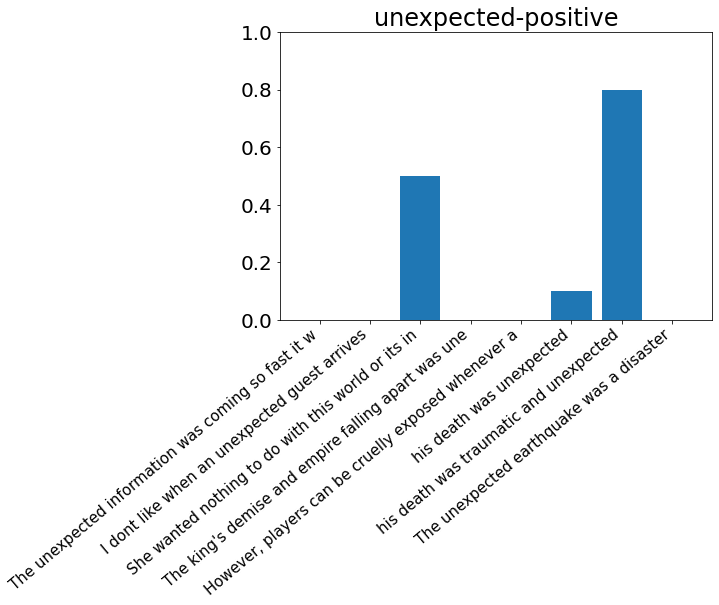

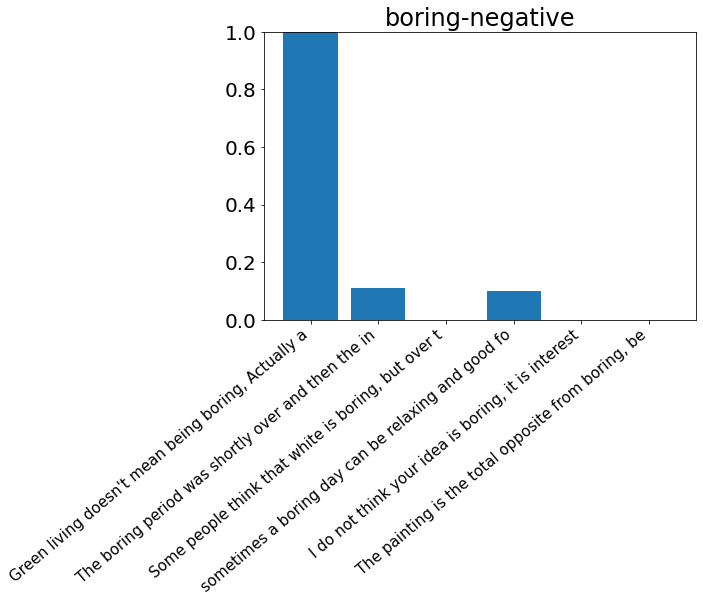

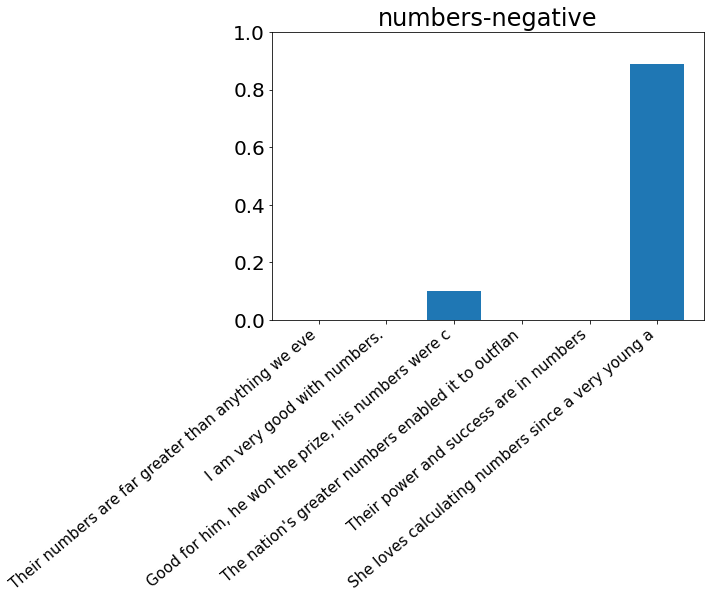

In [122]:
anchors_percent(anchor_sentences)